In [45]:
# Install the Noise2Void package for self-supervised image denoising
!pip install n2v


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [5]:
# Import TensorFlow for building and training neural networks
import tensorflow as tf

# Import the Noise2Void package for self-supervised image denoising
import n2v


In [6]:
# Import all the dependencies.

# Import configuration and model classes from Noise2Void
from n2v.models import N2VConfig, N2V

# Import NumPy for numerical operations
import numpy as np

# Import utility function for plotting training history from CSBDeep
from csbdeep.utils import plot_history

# Import utility functions for manipulating validation data in Noise2Void
from n2v.utils.n2v_utils import manipulate_val_data

# Import data generator class for Noise2Void
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator

# Import pyplot module from Matplotlib for plotting
from matplotlib import pyplot as plt

# Import modules for handling URL operations and file handling
import urllib
import os
import zipfile

# The following lines can be uncommented if SSL verification issues occur
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context


In [ ]:
# Import necessary libraries
import h5py  # For handling HDF5 files
from matplotlib import pyplot as plt  # For plotting
import numpy as np  # For numerical operations
from matplotlib.animation import ArtistAnimation, writers  # For creating animations
import cv2  # For computer vision tasks
import os  # For operating system interfaces
from skimage import io  # For image I/O operations

### Loading the dataset

In [8]:

# Define the path to the HDF5 file containing the JET videos
path = r"/scratch/project_2009706/git_files/AI_ML_tools/KLDT-E5WC_95775.h5"

# Open the HDF5 file in read mode
fhandler = h5py.File(path, "r")

# Access the dataset containing the video frames
dset = fhandler["frame_data"]

# Initialize an array to store the video data with the same shape and dtype as the dataset
video = np.zeros(dset.shape, dtype=dset.dtype)

# Copy the data from the dataset to the video array
video[:, :, :] = np.array(dset)

# Close the HDF5 file handler
fhandler.close()

# Print the shape of the video array to verify successful data loading
print(video.shape)


(1376, 176, 120)


**Training Data Preparation**


<p>
For training we can load a bunch of noisy images from a directory. Images can be of different sizes as we will be capturing them as a list, not an array. Of course, each image is an array. We will use the N2V_DataGenerator to extract training X and validation X_val patches.

In [46]:
# We create our DataGenerator-object.
# It will help us load data and extract patches for training and validation.
datagen = N2V_DataGenerator()


Note that the images need to be in float32 format owing to the way N2V is defined. But if you use your own way of loading images, you need to make sure they are converted to float32.

In [50]:
# Convert video frames into a list of images in the required format i.e. (1, width, height, channels)
# Initialize an empty list to store the reshaped images
imgs = []

# Loop through each frame in the video
for frame in video:
    # Reshape the frame to (1, width, height, channels)
    # Here, '1' represents the batch size, and '1' at the end represents the single color channel (grayscale)
    frame_re = frame.reshape(1, frame.shape[0], frame.shape[1], 1)
    
    # Append the reshaped frame to the list of images
    imgs.append(frame_re)

# Print the shape of the first loaded image to verify the transformation
print('Shape of the loaded image:', imgs[0].shape)


Shape of the loaded image: (1, 176, 120, 1)


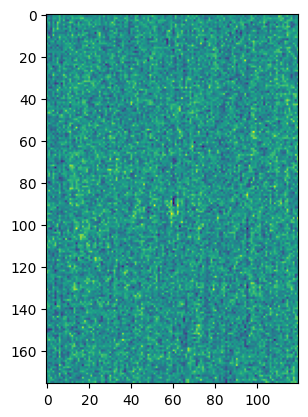

In [51]:
# Let's look at the image.
plt.figure()
plt.imshow(imgs[10][0,:,:,:])
plt.show()

In [ ]:
# Note - it is not mandatory to use all the images for training. Therefore, from the statistical point of view, a subset of images can be
# use for training which represents the whole datset. 
imgs = imgs[100:1100]

In [53]:
# Define the size of each patch to be extracted
patch_size = 32

# Specify the shape of the patches as (height, width)
patch_shape = (patch_size, patch_size)

# Patches are extracted from all images and combined into a single numpy array
patches = datagen.generate_patches_from_list(imgs, shape=patch_shape)

# Patches are created so they do not overlap.
# (Note: this is not the case if you specify a number of patches. See the docstring for details!)
# Non-overlapping patches enable us to split them into a training and validation set.

Generated patches: (120, 32, 32, 1)
Generated patches: (120, 32, 32, 1)
Generated patches: (120, 32, 32, 1)
Generated patches: (120, 32, 32, 1)
Generated patches: (120, 32, 32, 1)
Generated patches: (120, 32, 32, 1)
Generated patches: (120, 32, 32, 1)
Generated patches: (120, 32, 32, 1)
Generated patches: (120, 32, 32, 1)
Generated patches: (120, 32, 32, 1)
Generated patches: (120, 32, 32, 1)
Generated patches: (120, 32, 32, 1)
Generated patches: (120, 32, 32, 1)
Generated patches: (120, 32, 32, 1)
Generated patches: (120, 32, 32, 1)
Generated patches: (120, 32, 32, 1)
Generated patches: (120, 32, 32, 1)
Generated patches: (120, 32, 32, 1)
Generated patches: (120, 32, 32, 1)
Generated patches: (120, 32, 32, 1)
Generated patches: (120, 32, 32, 1)
Generated patches: (120, 32, 32, 1)
Generated patches: (120, 32, 32, 1)
Generated patches: (120, 32, 32, 1)
Generated patches: (120, 32, 32, 1)
Generated patches: (120, 32, 32, 1)
Generated patches: (120, 32, 32, 1)
Generated patches: (120, 32,

In [54]:
# Define the fraction of patches to be used for training
training_size = 0.7

# Calculate the index to split the patches into training and validation sets
# This splits the data so that 'training_size' fraction is used for training
train_val_split = int(patches.shape[0] * training_size)

# Extract the training patches from the beginning of the array up to the split index
X = patches[:train_val_split]

# Extract the validation patches from the split index to the end of the array
X_val = patches[train_val_split:]

# Print the shapes of the training and validation sets to verify the split
print(f'Shape of training patches: {X.shape}')
print(f'Shape of validation patches: {X_val.shape}')


Shape of training patches: (115583, 32, 32, 1)
Shape of validation patches: (49537, 32, 32, 1)


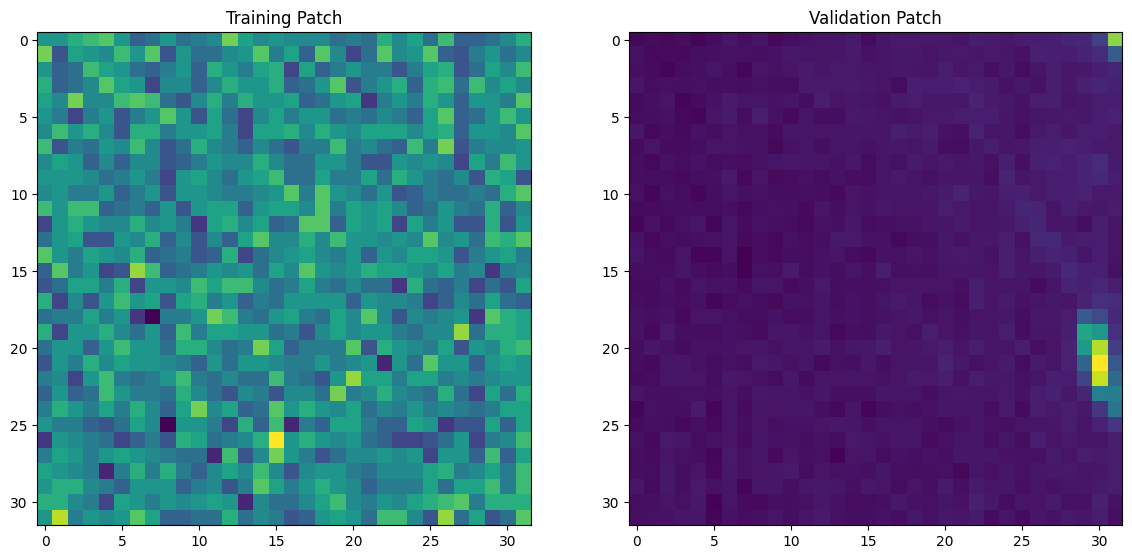

In [56]:
# Visualize two patches: one from the training set and one from the validation set

# Create a figure with a specified size for displaying the patches
plt.figure(figsize=(14, 7))

# Plot the first training patch
plt.subplot(1, 2, 1)  # Create a subplot with 1 row, 2 columns, and position 1
plt.imshow(X[0, ..., 0], cmap='viridis')  # Display the first training patch in grayscale
plt.title('Training Patch')  # Set the title for the training patch subplot

# Plot the first validation patch
plt.subplot(1, 2, 2)  # Create a subplot with 1 row, 2 columns, and position 2
plt.imshow(X_val[0, ..., 0], cmap='viridis')  # Display the first validation patch in grayscale
plt.title('Validation Patch')  # Set the title for the validation patch subplot

# Display the figure with the two patches
plt.show()


### From the noise2void repository
<h2>Configure</h2><p>

Noise2Void comes with a special config-object, where we store network-architecture and training specific parameters. See the docstring of the N2VConfig constructor for a description of all parameters.
<p>
When creating the config-object, we provide the training data X. From X we extract mean and std that will be used to normalize all data before it is processed by the network. We also extract the dimensionality and number of channels from X.
<p>
To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter n2v_manipulator with default value 'uniform_withCP'. Most pixel manipulators will compute the replacement value based on a neighborhood. With n2v_neighborhood_radius we can control its size.
<p>
<h3>Other pixel manipulators:</h3>
<p>
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
<br>
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = n2v_neighborhood_radius
<br>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
<br>
* identity: performs no pixel manipulation
<br>

<p>
For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size n2v_patch_shape are extracted during training. Default patch shape is set to (64, 64).
<p>
There has been bleedthrough artifacts between channels if training was terminated to early. To counter bleedthrough we added the single_net_per_channel option, which is turned on by default. In the back a single U-Net for each channel is created and trained independently, thereby removing the possiblity of bleedthrough.<br>
Note: Essentially the network gets multiplied by the number of channels, which increases the memory requirements. If your GPU gets too small, you can always split the channels manually and train a network for each channel one after another.
<p>


In [58]:
# Set up the configuration for the Noise2Void model

# Define the batch size for training
train_batch = 32

# Create an N2VConfig object with the specified parameters
config = N2VConfig(
    X,  # Training data
    unet_kern_size=3,  # Kernel size for the UNet model
    axes='YXC',  # The order of axes in the input data (Y: height, X: width, C: channels)
    unet_n_first=64,  # Number of filters in the first layer of the UNet model
    unet_n_depth=3,  # Depth of the UNet model (number of downsampling steps)
    train_steps_per_epoch=int(X.shape[0] / train_batch),  # Number of training steps per epoch
    train_epochs=300,  # Number of epochs for training
    train_loss='mse',  # Loss function used for training (Mean Squared Error)
    batch_norm=True,  # Whether to use batch normalization in the UNet model
    train_batch_size=train_batch,  # Batch size for training
    n2v_perc_pix=0.198,  # Percentage of pixels manipulated in each patch
    n2v_patch_shape=(patch_size, patch_size),  # Shape of patches used for training
    n2v_manipulator='uniform_withCP',  # Type of data manipulation used (uniform with context pixels)
    n2v_neighborhood_radius=5,  # Radius of the neighborhood used for manipulation
    single_net_per_channel=False  # Whether to use a single network for all channels (False means separate networks)
)

# Display the parameters stored in the N2VConfig object to review the configuration
vars(config)


{'means': ['470.82602'],
 'stds': ['1349.4048'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 3,
 'unet_n_first': 64,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 300,
 'train_steps_per_epoch': 3611,
 'train_learning_rate': 0.0004,
 'train_batch_size': 32,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (32, 32),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': False,
 'blurpool': False,
 'skip_skipone': False,
 'structN2Vmask': None,
 'probabilistic': False}

In [59]:
# Define a name for the model to identify it
# Note: Change this to something descriptive or specific to your experiment
model_name = 'n2v_pulse_94554'

# Specify the base directory where the model files will be stored
basedir = 'models'

# Create the Noise2Void network model using the defined configuration
# The model will be saved in the specified base directory with the given model name
model = N2V(config, model_name, basedir=basedir)

# Print a confirmation message to indicate that the model has been created
print(f'Model "{model_name}" has been created and will be saved in the directory "{basedir}".')


/users/sethihar/.local/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /scratch/project_2009706/git_files/AI_ML_tools/models/n2v_pulse_94554
  warnings.warn(


Model "n2v_pulse_94554" has been created and will be saved in the directory "models".


<h2>Training</h2><p>


In [ ]:
# Start training the Noise2Void model using the prepared training and validation patches

# Train the model with the training data (X) and validate it using the validation data (X_val)
# The training process will use the configuration and parameters specified in the N2VConfig object
history = model.train(X, X_val)

# Print a confirmation message indicating that the training has started
print('Training has started.')


In [ ]:
# Print the sorted list of keys from the training history dictionary
# This helps to understand what metrics are available for plotting
print(sorted(list(history.history.keys())))

# Create a figure to visualize the training history
plt.figure(figsize=(16, 5))

# Plot the training and validation loss over epochs
# The 'plot_history' function visualizes the specified metrics ('loss' and 'val_loss') from the history object
plot_history(history, ['loss', 'val_loss'])

# Display the figure with the training and validation loss curves
plt.show()


<h1>Denoising images using the trained model</h1>

In [61]:
# We import all our dependencies.
from n2v.models import N2V
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.image import imread, imsave
from csbdeep.io import save_tiff_imagej_compatible

In [62]:
# Load a previously trained Noise2Void model

# Define the name of the previously trained model and the directory where it is stored
model_name = 'n2v_pulse_94554'
basedir = 'models'

# Create a new N2V object to load the previously trained model
# The 'config' argument is set to None because we are loading a model, not creating a new one
model = N2V(config=None, name=model_name, basedir=basedir)

# Print a confirmation message indicating that the model has been loaded
print(f'Model "{model_name}" has been loaded from the directory "{basedir}".')


Loading network weights from 'weights_best.h5'.


Denoising (prediction)

In [65]:
# Load the data we want to process
# Here we access the first image from the list of images and select the first frame
img = imgs[0][0]

# Print the shape of the loaded image to verify dimensions
print(img.shape)

# Denoise the image using the previously trained Noise2Void model
# The 'predict' method is used to perform denoising on the image
# The parameter 'axes' specifies the order of dimensions in the image (Y: height, X: width, C: channels)
# If the image is too large for GPU memory, the 'n_tiles' parameter can be used to split the image into smaller tiles
# If 'n_tiles' is not provided, the system will attempt to determine an appropriate tiling automatically, which may take longer
pred = model.predict(img, axes='YXC')

# Print a confirmation message to indicate that the denoising process is complete
print('Image denoising complete.')


(176, 120, 1)
1/1 [==============================] - 0s 19ms/step
Image denoising complete.


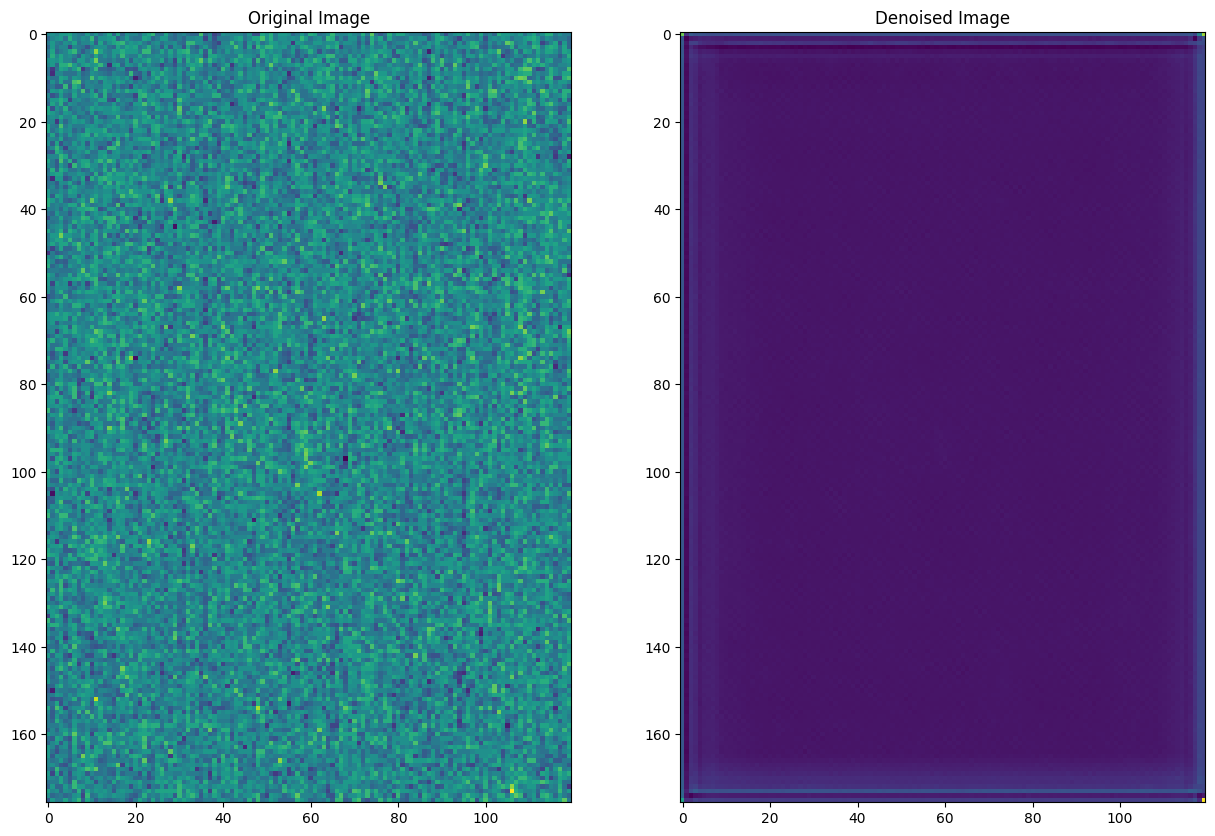

In [67]:
# Visualize and compare the original and denoised images

# Create a figure with a specified size for displaying the images side by side
plt.figure(figsize=[15, 10])

# Plot the original image on the left
plt.subplot(1, 2, 1)  # Create a subplot with 1 row, 2 columns, and position 1 (left side)
plt.imshow(img, cmap='viridis')  # Display the original image in grayscale
plt.title('Original Image')  # Set the title for the original image subplot

# Plot the denoised image on the right
plt.subplot(1, 2, 2)  # Create a subplot with 1 row, 2 columns, and position 2 (right side)
plt.imshow(pred[:, :, 0], cmap='viridis')  # Display the denoised image with 'viridis' colormap
plt.title('Denoised Image')  # Set the title for the denoised image subplot

# Show the figure with both images
plt.show()


# Inference

In [76]:
from scipy.ndimage import gaussian_filter

In [77]:
# Load the video data from the HDF5 file for inference

# Open the HDF5 file in read mode
file = h5py.File('/scratch/project_2009706/git_files/AI_ML_tools/KLDT-E5WC_95775.h5', 'r')

# Access the dataset containing the video frames
video = file['frame_data']

# Print the shape of the video dataset to verify its dimensions
# This provides information about the number of frames, height, and width of the video
print(video.shape)


(1376, 176, 120)


1/1 [==============================] - 0s 19ms/step


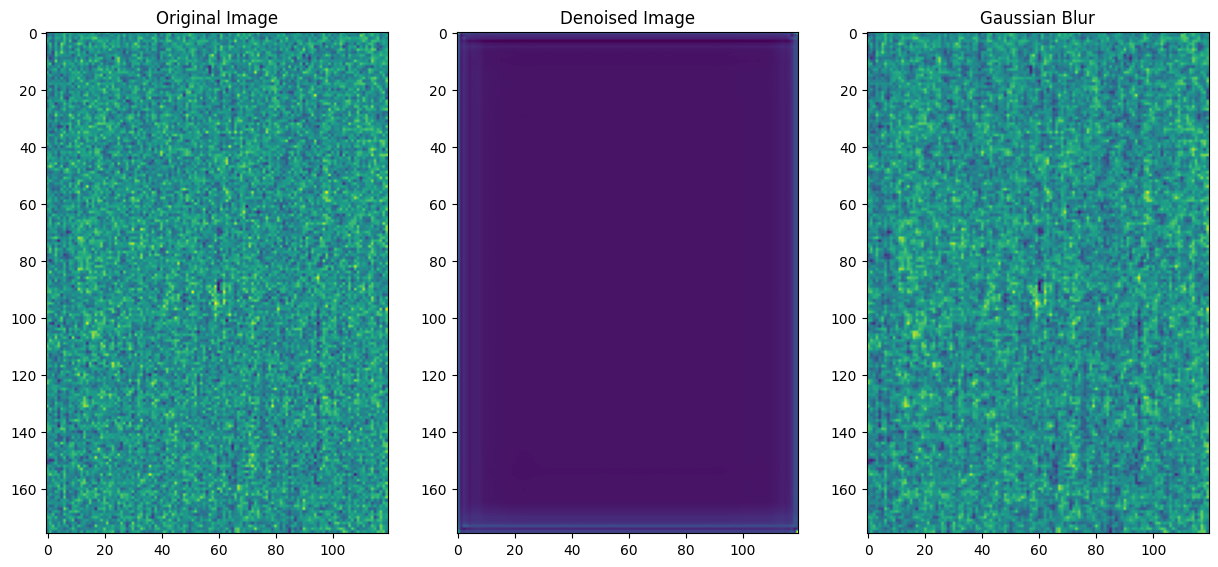

In [82]:
# Perform denoising on the image using the trained model
pred = model.predict(img, axes='YXC')

# Create a figure for displaying the images
plt.figure(figsize=[15, 10])

# Display the original image
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='viridis')
plt.title('Original Image')

# Display the denoised image
plt.subplot(1, 3, 2)
plt.imshow(pred[:, :, 0], cmap='viridis')
plt.title('Denoised Image')

# Apply Gaussian denoising to the image and display the result
gauss = gaussian_filter(img, sigma=0.5)
plt.subplot(1, 3, 3)
plt.imshow(gauss, cmap='viridis')
plt.title('Gaussian Blur')

# Render the figure with all images
plt.show()


In [83]:
# Create an empty array to store the filtered video
video_filtered = np.empty(video.shape)

# Loop through each frame of the video
for i in range(video.shape[0]):
    # Predict the filtered frame using the model
    # Reshape each frame to match the expected input shape and then reshape the output back to the original frame shape
    video_filtered[i, :, :] = model.predict(video[i].reshape(video.shape[1], video.shape[2], 1), axes='YXC').reshape(video.shape[1], video.shape[2])


1/1 [==============================] - 0s 17ms/step


KeyboardInterrupt: 

In [94]:
# Define the directory name and pulse number
dir_name = 'n2v_files'
pulse_number = 95775

# Construct the file path by joining the current working directory, directory name, and file name
path = os.path.join(os.getcwd(), dir_name, f'n2v_{pulse_number}.h5')

# Print the constructed file path for verification
print(f'File path: {path}')


File path: /scratch/project_2009706/git_files/AI_ML_tools/n2v_files/n2v_95775.h5


In [ ]:
# Check if the directory exists, and create it if it does not
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

# Open an HDF5 file in write mode and create a dataset
with h5py.File(path, 'w') as f:
    # Create a dataset within the file to store the video data
    dataset = f.create_dataset('frame_data', data=video_filtered)
